In [1]:
### Import packages 
import networkx as nx # for handling graphs/networks 
import numpy as np # for basic scientific computing 
import pandas as pd # for basic scientific computing 
import matplotlib.pyplot as plt # for plotting
import matplotlib.gridspec as gridspec
from scipy.special import binom

from scipy.integrate import solve_ivp
import Koopman_source as kp
from math import comb
#from copy import copy
import csv

In [2]:
## Toy example from the Steven's note
# Discrete dynamical system

def toy_d1(t, x0, mu0, lambda0): # Here, d1 stands for the first discrete example.
    # t must be a positive integer.
    # x0 is the initial value x(0) = x0
    #mu0, lambda0 = kappa[0], kappa[1]
    x_mat = np.zeros([len(x0),t]) # matrix for saving trajectories. It does not save the initial value.
    x_old = x0.copy()
    x_new = x_old
    for i in range(t):
        x_new[0] = (1+mu0)*x_old[0]
        x_new[1] = (1+lambda0)*x_old[1]
        x_mat[:,i] = x_new
    return x_mat

def toy_d1_F(x_old, mu0, lambda0):
    x_new = x_old.copy()
    x_new[0] = (1+mu0)*x_old[0]
    x_new[1] = (1+lambda0)*x_old[1]
    return x_new

def toy_d2_F(x_old, mu0, lambda0):
    x_new = x_old.copy()
    x_new[0] = (1+mu0)*x_old[0]
    x_new[1] = (1+lambda0)*x_old[1] - lambda0 * np.power(x_old[0],2)
    return x_new

def toy_d2_Koopman(x_old, mu0, lambda0):
    x_new = x_old.copy()
    x_new[0] = (1+mu0)*x_old[0]
    x_new[1] = (1+lambda0)*x_old[1] - lambda0 * x_old[2]
    x_new[2] = np.power((1+mu0), 2)*x_old[2]
    return x_new

def toy_d3_F(x_old, mu0, lambda0, gamma0, k1, k2, k3, k4):
    x_new = x_old.copy()
    x_new[0] = (1+mu0)*x_old[0]
    x_new[1] = (1+lambda0)*x_old[1] + k1 * x_old[2] - k2 * np.power(x_old[0],2)
    x_new[2] = (1+gamma0)*x_old[2] + k3 * x_old[0] - k4 * np.power(x_old[0],2)
    return x_new

def toy_d3_Koopman(x_old, mu0, lambda0):
    x_new = x_old.copy()
    x_new[0] = (1+mu0)*x_old[0]
    x_new[1] = (1+lambda0)*x_old[1] + k1 * x_old[2] - k2 * x_old[3]
    x_new[2] = (1+gamma0)*x_old[2] + k3 * x_old[0] - k4 * x_old[3]
    x_new[3] = np.power((1+mu0), 2)*x_old[3]
    return x_new


def psi_id(x):
    return x
    
def psi_d1(x):
    return x

def psi_d2(x):
    d = 2 # the number of variables or the dimension of a dynamical system.
    max_order = 2
    num_obs = comb(max_order+d, d)# (d+max_order)Cd = dH0 + dH1 + \cdots dHmax_order by the hockey stick rule where H is repeated combination nHr = (n+r-1)Cr
    obs = np.zeros(num_obs) # the total number of observable functions, psi_m's.
    idx = 0 
    for i in range(max_order+1):
        for j in range(i+1):
            obs[idx] = np.power(x[0], i-j) * np.power(x[1], j)
            idx += 1
    return obs

def Laguerre_poly(x, n):
    if n==0:
        return 1
    if n==1:
        return -x+1
    if n==2:
        return 1/2 * (x**2 - 4*x + 2)
    if n==3:
        return 1/6 * (-x**3 + 9*x**2 - 18*x + 6)
    if n==4:
        return 1/24 * (x**4 - 16*x**3 + 72*x**2 - 96*x + 24)
    print("For now, n must be less than 5!")
    return None

def psi_d2_Laguerre(x):
    d = 2 # the number of variables or the dimension of a dynamical system.
    max_order = 2
    num_obs = comb(max_order+d, d)# (d+max_order)Cd = dH0 + dH1 + \cdots dHmax_order by the hockey stick rule where H is repeated combination nHr = (n+r-1)Cr
    obs = np.zeros(num_obs) # the total number of observable functions, psi_m's.
    idx = 0 
    for i in range(max_order+1):
        for j in range(i+1):
            obs[idx] = Laguerre_poly(x[0], i-j) * Laguerre_poly(x[1], j)
            idx += 1
    return obs


def psi_d3(x):
    d = 3 # the number of variables or the dimension of a dynamical system.
    max_order = 3
    num_obs = comb(max_order+d, d)# (d+max_order)Cd = dH0 + dH1 + \cdots dHmax_order by the hockey stick rule where H is repeated combination nHr = (n+r-1)Cr
    obs = np.zeros(num_obs) # the total number of observable functions, psi_m's.

    obs = np.zeros(19) # 20 = the total number of observable functions, psi_m's.
    idx = 0 
    for i in range(max_order+1):
        for j in range(i+1):
            for k in range(i-j+1):
                obs[idx] = np.power(x[0], i-j-k) * np.power(x[1], k) * np.power(x[2], j)
                idx += 1
                #print(i-j-k, k, j)
    return obs


def psi_d2_ans(x):
    obs = np.zeros(3) # = the total number of observable functions, psi_m's.
    obs[0] = x[0]
    obs[1] = x[1]
    obs[2] = np.power(x[0],2)
    return obs
            

In [13]:
np.random.seed(123)

## Compute a Koopman matrix from simulated data.
mu0 = -0.1
lambda0 = -0.2
gamma0 = -0.15
k1 = 0.1
k2 = 0.2
k3 = 0.1
k4 = 0.15

K_true = np.array([[1+mu0, 0, 0], [0, 1+lambda0, -lambda0], [0, 0, (1+mu0)**2]])
G_inv_true = np.array([[11/4, -3/4, -5/8], [-3/4, 3/4, 1/8], [-5/8, 1/8, 3/16]])
G_true = np.array([[2,1,6],[1,2,2,],[6,2,24]])
np.matmul(G_inv_true, G_true)
A_true = np.matmul(G_true, np.transpose(K_true))

#x0 = [2,1]

model = "d2"

if model == "d2_ans":
    d = 2
elif model == "d2":
    d = 2 # the number of variables (=the dimension) of the original dynamical system.
elif model == "d3":
    d = 3
#M = 100 # the number of observed data. 

orth_basis = True

M_max = 200 # the maximum number of observed data. 
n_repeat = 1000 # the number of repetition of approximaing the Koopman matrix. 
max_order = 2
N = comb(d+max_order,d) # the total number of observable functions, psi_m's. 

#N = 9

K_approx_cp = np.zeros([N,N,M_max])
G_approx_cp = np.zeros([N,N,M_max])
G_pinv_cp = np.zeros([N,N,M_max])
K_approx_cp_accum = np.zeros([N,N,M_max,n_repeat])
G_approx_cp_accum = np.zeros([N,N,M_max,n_repeat])
G_pinv_cp_accum = np.zeros([N,N,M_max,n_repeat])


K_approx = np.zeros([N,N,M_max])
G_approx = np.zeros([N,N,M_max])
G_pinv = np.zeros([N,N,M_max])
A_approx = np.zeros([N,N,M_max])
K_approx_accum = np.zeros([N,N,M_max,n_repeat])
G_approx_accum = np.zeros([N,N,M_max,n_repeat])
G_pinv_accum = np.zeros([N,N,M_max,n_repeat])
A_approx_accum = np.zeros([N,N,M_max,n_repeat])

cumul = True


for rr in range(n_repeat):
    x_mat_total = np.random.default_rng().exponential(scale=1, size=[d,M_max])
    xg_mat_total = np.random.default_rng().exponential(scale=1, size=[d,M_max])
    y_mat_total = np.zeros([d,M_max])
    for M in range(1,M_max+1):  
        if cumul == True:
            x_mat = x_mat_total[np.ix_(range(d),range(M))]
            xg_mat = xg_mat_total[np.ix_(range(d),range(M))]
            y_mat = y_mat_total[np.ix_(range(d),range(M))]
        else:
            x_mat = np.random.default_rng().exponential(scale=1, size=[d,M])
            xg_mat = np.random.default_rng().exponential(scale=1, size=[d,M])
            y_mat = np.zeros([d,M])

        for i in range(M):
            if model == "d2_ans":
                y_mat[:,i] = toy_d2_F(x_mat[:,i], mu0, lambda0)
            elif model == "d2":
                y_mat[:,i] = toy_d2_F(x_mat[:,i], mu0, lambda0)
            elif model == "d3":
                y_mat[:,i] = toy_d3_F(x_mat[:,i], mu0, lambda0, gamma0, k1, k2, k3, k4)

        psi_X = np.zeros([M,N])
        psi_Xg = np.zeros([M,N])
        psi_Y = np.zeros([M,N])
        for i in range(M):
            if model == "d2_ans":
                    psi_X[i,:] = psi_d2_ans(x_mat[:,i])
                    psi_Y[i,:] = psi_d2_ans(y_mat[:,i])
                    psi_Xg[i,:] = psi_d2_ans(xg_mat[:,i])
            elif model == "d2":
                if orth_basis:
                    psi_X[i,:] = psi_d2_Laguerre(x_mat[:,i])
                    psi_Y[i,:] = psi_d2_Laguerre(y_mat[:,i])
                    psi_Xg[i,:] = psi_d2_Laguerre(xg_mat[:,i])
                else:
                    psi_X[i,:] = psi_d2(x_mat[:,i])
                    psi_Y[i,:] = psi_d2(y_mat[:,i])
                    psi_Xg[i,:] = psi_d2(xg_mat[:,i])
            elif model == "d3":
                psi_X[i,:] = psi_d3(x_mat[:,i])
                psi_Y[i,:] = psi_d3(y_mat[:,i])

        G_approx[:,:,M-1] = 1/M * np.matmul(psi_Xg.transpose(), psi_Xg) # N x N matrix
        G_approx_cp[:,:,M-1] = 1/M * np.matmul(psi_X.transpose(), psi_X) # N x N matrix
        A_approx[:,:,M-1] = 1/M * np.matmul(psi_X.transpose(), psi_Y) # N x N matrix
        
        G_pinv[:,:,M-1] = np.linalg.pinv(G_approx[:,:,M-1]) # N x N matrix
        K_approx[:,:,M-1] = np.matmul(G_pinv[:,:,M-1], A_approx[:,:,M-1]).transpose()  # N x N matrix
        
        G_pinv_cp[:,:,M-1] = np.linalg.pinv(G_approx_cp[:,:,M-1]) # N x N matrix
        K_approx_cp[:,:,M-1] = np.matmul(G_pinv_cp[:,:,M-1], A_approx[:,:,M-1]).transpose()  # N x N matrix        

    G_approx_accum[:,:,:,rr] = G_approx
    G_pinv_accum[:,:,:,rr] = G_pinv
    G_approx_cp_accum[:,:,:,rr] = G_approx_cp
    G_pinv_cp_accum[:,:,:,rr] = G_pinv_cp
    A_approx_accum[:,:,:,rr] = A_approx

    K_approx_cp_accum[:,:,:,rr] = K_approx_cp
    K_approx_accum[:,:,:,rr] = K_approx



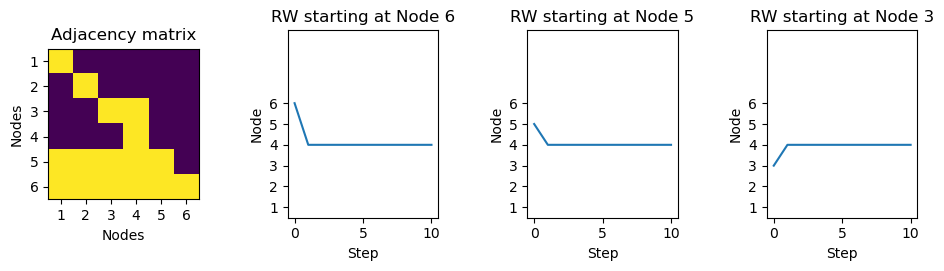

In [5]:
# This block of codes is for the 2-dimensional K matrix array.
#print(K_approx[:,:,950])
m_vis = M-1
#P_bool = np.absolute(K_approx[:,:,m_vis]) > 1e-2
P_bool = np.absolute(K_approx_cp[:,:,m_vis]) > 1e-2
P = P_bool.astype(int) # this matrix considered as the edge probability matrix to obtain a directed graph. 
G = kp.weight2digraph(P)
A = nx.adjacency_matrix(G, nodelist=list(G.nodes()))

nstep = 10
init1 = int(np.floor(N*np.random.default_rng().uniform()))
init2 = int(np.floor(N*np.random.default_rng().uniform()))
init3 = int(np.floor(N*np.random.default_rng().uniform()))
# print(type(A1))
rw1 = kp.RW(G, x0 = init1, steps = nstep, return_history = True)
rw1.insert(0,init1)
rw2 = kp.RW(G, x0= init2, steps = nstep, return_history = True)
rw2.insert(0,init2)
rw3 = kp.RW(G, x0 = init3, steps = nstep, return_history = True)
rw3.insert(0,init3)

fig, ax = plt.subplots(1, 4, figsize = (10,3))
fig.tight_layout(pad=3.0)
fn = 0

ax[fn].imshow(A.todense());
ax[fn].set_xticks(np.arange(0, N),[str(x) for x in np.arange(1, N+1)]);
ax[fn].set_yticks(np.arange(0, N),[str(x) for x in np.arange(1, N+1)]);
ax[fn].set_xlabel('Nodes');
ax[fn].set_ylabel('Nodes');
ax[fn].set_title('Adjacency matrix');
fn += 1


ax[fn].plot(rw1)
ax[fn].set_yticks(np.arange(0, N),[str(x) for x in np.arange(1, N+1)]);
ax[fn].set_ylim([-0.5, 8.5]);
ax[fn].set_xlabel('Step');
ax[fn].set_ylabel('Node');
ax[fn].set_title(f"RW starting at Node {init1 + 1}");
fn += 1

ax[fn].plot(rw2)
ax[fn].set_yticks(np.arange(0, N),[str(x) for x in np.arange(1, N+1)]);
ax[fn].set_ylim([-0.5, 8.5]);
ax[fn].set_xlabel('Step');
ax[fn].set_ylabel('Node');
ax[fn].set_title(f"RW starting at Node {init2 + 1}");
fn += 1

ax[fn].plot(rw3)
ax[fn].set_yticks(np.arange(0, N),[str(x) for x in np.arange(1, N+1)])
ax[fn].set_ylim([-0.5, 8.5]);
ax[fn].set_xlabel('Step');
ax[fn].set_ylabel('Node');
ax[fn].set_title(f"RW starting at Node {init3 + 1}");
#plt.savefig('Results_9obs.png')

In [14]:
var_mat_K_approx = np.zeros([N,N,M_max])
mean_mat_K_approx = np.zeros([N,N,M_max])
var_mat_K_approx_cp = np.zeros([N,N,M_max])
mean_mat_K_approx_cp = np.zeros([N,N,M_max])

var_mat_G_approx_cp = np.zeros([N,N,M_max])
mean_mat_G_approx_cp = np.zeros([N,N,M_max])
var_mat_G_pinv_cp = np.zeros([N,N,M_max])
mean_mat_G_pinv_cp = np.zeros([N,N,M_max])
var_mat_G_approx = np.zeros([N,N,M_max])
mean_mat_G_approx = np.zeros([N,N,M_max])
var_mat_G_pinv = np.zeros([N,N,M_max])
mean_mat_G_pinv = np.zeros([N,N,M_max])
var_mat_A_approx = np.zeros([N,N,M_max])
mean_mat_A_approx = np.zeros([N,N,M_max])

var_mat = np.zeros([N,N,M_max])
mean_mat = np.zeros([N,N,M_max])


num_avg = 1000 # num_avg = n_repeat
for ii in range(N):
    for jj in range(N):
        for mm in range(M_max):
            var_mat_K_approx_cp[ii,jj,mm] = np.var(K_approx_cp_accum[ii,jj,mm,range(num_avg)])
            mean_mat_K_approx_cp[ii,jj,mm] = np.mean(K_approx_cp_accum[ii,jj,mm,range(num_avg)])
            var_mat_K_approx[ii,jj,mm] = np.var(K_approx_accum[ii,jj,mm,range(num_avg)])
            mean_mat_K_approx[ii,jj,mm] = np.mean(K_approx_accum[ii,jj,mm,range(num_avg)])

            var_mat_G_approx_cp[ii,jj,mm] = np.var(G_approx_cp_accum[ii,jj,mm,range(num_avg)])
            mean_mat_G_approx_cp[ii,jj,mm] = np.mean(G_approx_cp_accum[ii,jj,mm,range(num_avg)])
            var_mat_G_approx[ii,jj,mm] = np.var(G_approx_accum[ii,jj,mm,range(num_avg)])
            mean_mat_G_approx[ii,jj,mm] = np.mean(G_approx_accum[ii,jj,mm,range(num_avg)])

            var_mat_G_pinv_cp[ii,jj,mm] = np.var(G_pinv_cp_accum[ii,jj,mm,range(num_avg)])
            mean_mat_G_pinv_cp[ii,jj,mm] = np.mean(G_pinv_cp_accum[ii,jj,mm,range(num_avg)])
            var_mat_G_pinv[ii,jj,mm] = np.var(G_pinv_accum[ii,jj,mm,range(num_avg)])
            mean_mat_G_pinv[ii,jj,mm] = np.mean(G_pinv_accum[ii,jj,mm,range(num_avg)])

            var_mat_A_approx[ii,jj,mm] = np.var(A_approx_accum[ii,jj,mm,range(num_avg)])
            mean_mat_A_approx[ii,jj,mm] = np.mean(A_approx_accum[ii,jj,mm,range(num_avg)])



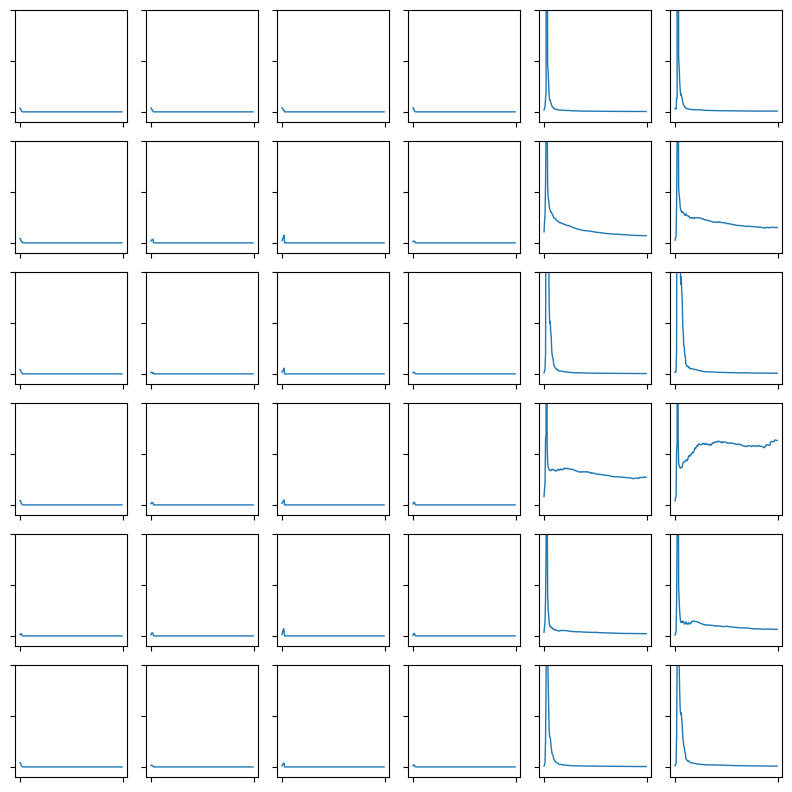

In [22]:
# This block of codes is for the 3-dimensional K matrix array.

# Draw the evolution of each entry in the Koopman matrix approximated with increasing number of data from 1 to 100.
iter_range = range(M_max)
#i_list = [1,2,3]
#j_list = [1,2,3]
i_list = range(N)
j_list = range(N)
ylim0 = [-0.1, 1]

# K_approx_plot = K_approx_cp
#K_approx_plot = K_approx_cp_accum[:,:,:,4]
mean_plot = var_mat_K_approx_cp
#var_plot = var_mat_K_approx_cp

fig2, ax2 = plt.subplots(len(i_list), len(j_list), figsize = (8,8))
#fig2.tight_layout(pad=3.0)
for ic in range(len(i_list)):
    for jc in range(len(j_list)):
        i = i_list[ic]
        j = j_list[jc]
        #ax2[i,j].plot(iter_range, K_approx_plot[i,j,iter_range] - K_true[i,j], linewidth = 0.2)
        #ax2[ic,jc].plot(iter_range, K_approx_plot[i,j,iter_range], linewidth = 1)
        ax2[ic,jc].plot(iter_range, mean_plot[j,i,iter_range], linewidth = 1)
        #ax2[ic,jc].fill_between(iter_range,  mean_plot[j,i,iter_range] - np.sqrt(var_plot[j,i,iter_range]), mean_plot[j,i,iter_range] + np.sqrt(var_plot[j,i,iter_range]), alpha = 0.3)
        # Here we plot K[j,i] instead of K[i,j] to take the transpose.

        ax2[ic,jc].set_ylim(ylim0)
        ax2[ic,jc].set_xticklabels('')
        ax2[ic,jc].set_yticklabels('')
        
fig2.tight_layout(pad=1.0)
# plt.savefig('K_approx_cp_diff.png')

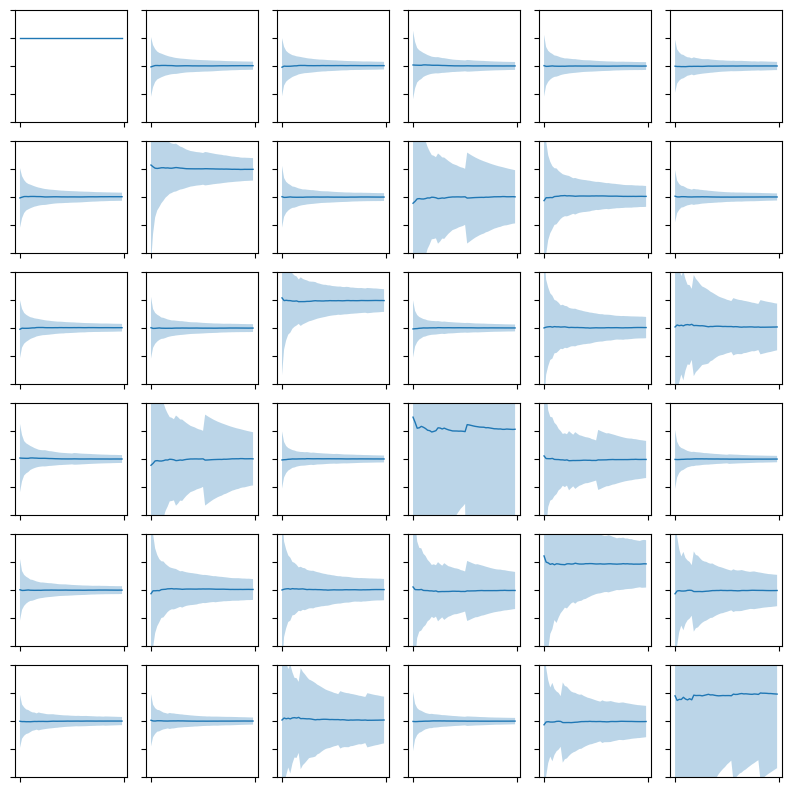

In [6]:
# This block of codes is for the 3-dimensional K matrix array.

# Draw the evolution of each entry in the Koopman matrix approximated with increasing number of data from 1 to 100.
iter_range = range(M_max)
#i_list = [1,2,3]
#j_list = [1,2,3]
i_list = range(N)
j_list = range(N)
ylim0 = [-2, 2]

# K_approx_plot = K_approx_cp
#K_approx_plot = K_approx_cp_accum[:,:,:,4]
mean_plot = mean_mat_G_approx
var_plot = var_mat_G_approx

fig2, ax2 = plt.subplots(len(i_list), len(j_list), figsize = (8,8))
#fig2.tight_layout(pad=3.0)
for ic in range(len(i_list)):
    for jc in range(len(j_list)):
        i = i_list[ic]
        j = j_list[jc]
        #ax2[i,j].plot(iter_range, K_approx_plot[i,j,iter_range] - K_true[i,j], linewidth = 0.2)
        #ax2[ic,jc].plot(iter_range, K_approx_plot[i,j,iter_range], linewidth = 1)
        ax2[ic,jc].plot(iter_range, mean_plot[j,i,iter_range], linewidth = 1)
        ax2[ic,jc].fill_between(iter_range,  mean_plot[j,i,iter_range] - np.sqrt(var_plot[j,i,iter_range]), mean_plot[j,i,iter_range] + np.sqrt(var_plot[j,i,iter_range]), alpha = 0.3)
        # Here we plot K[j,i] instead of K[i,j] to take the transpose.

        ax2[ic,jc].set_ylim(ylim0)
        ax2[ic,jc].set_xticklabels('')
        ax2[ic,jc].set_yticklabels('')
        
fig2.tight_layout(pad=1.0)
# plt.savefig('K_approx_cp_diff.png')

In [ ]:


#np.set_printoptions(suppress=True)
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

submat = np.arange(7)
#np.round(K_approx[submat,submat,900], 2)
print(K_approx[:,:,m_vis])
#model
DF1 = pd.DataFrame(np.round(K_approx[:,:,m_vis], 2)) 
#DF1.to_csv("K_current_d2_Lag.csv")
#psi_d3([0,0,0])
print(K_true)



In [17]:
range(3)

range(0, 3)